# Homegrown Fruit and Vegetable Prices in the UK

### Data set contains average wholesale prices of selected home-grown horticultural produce in England and Wales. These are averages of the most usual prices charged by wholesalers for selected home-grown fruit, vegetables and cut flowers at the wholesale markets in UK

###### Data provided by Kaggle - https://www.kaggle.com/datasets/datota/fruit-and-vegatable-prices-in-uk-2017-2022

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#inport data
data = pd.read_csv('fruitvegprices-2017_2022.csv')

### Subset for fruits and vegetables

In [32]:
data = data[data['category'].isin(['fruit', 'vegetable'])]

category            object
item                object
variety             object
date        datetime64[ns]
price              float64
unit                object
Year                object
Month               object
dtype: object

In [15]:
print('\033[1m' + 'Contains pricing data for the following produce' + '\033[0m')

for cat in data['category'].unique():
    items = data[data['category']==cat]['item'].unique()
    cata = "{0}s ({1}):".format(cat, len(items))
    print()
    print('\033[1m' + cata + '\033[0m')
    for i in items:
        var = data[(data['category']==cat) & (data['item']==i)]['variety'].unique()
        
        if len(var)>1:
            print("\t{0} - {1} varieties".format(i, len(var)))
        else:
            print("\t{0} - {1} variety".format(i, len(var)))
            

Contains pricing data for the following produce

fruits (10):
	apples - 8 varieties
	pears - 3 varieties
	raspberries - 1 variety
	strawberries - 1 variety
	blackberries - 1 variety
	currants - 2 varieties
	blueberries - 1 variety
	plums - 2 varieties
	cherries - 1 variety
	gooseberries - 1 variety

vegetables (32):
	beetroot - 1 variety
	brussels_sprouts - 1 variety
	pak_choi - 1 variety
	curly_kale - 1 variety
	cabbage - 5 varieties
	spring_greens - 1 variety
	carrots - 1 variety
	cauliflower - 1 variety
	celeriac - 1 variety
	cucumbers - 1 variety
	leeks - 1 variety
	lettuce - 4 varieties
	onion - 3 varieties
	swede - 1 variety
	turnip - 1 variety
	parsnips - 1 variety
	rhubarb - 2 varieties
	capsicum - 4 varieties
	chinese_leaf - 1 variety
	celery - 1 variety
	tomatoes - 4 varieties
	coriander - 1 variety
	spinach_leaf - 1 variety
	calabrese - 1 variety
	rocket - 1 variety
	mixed_babyleaf_salad - 1 variety
	sweetcorn - 1 variety
	beans - 3 varieties
	courgettes - 1 variety
	peas - 

In [20]:
from datetime import datetime

data['date'] = pd.to_datetime(data['date'])

#set Year and month valeus
data['Year'] = data.date.dt.strftime('%Y')
data['Month'] = data.date.dt.strftime('%m')

#order by date
dataOrdered = data.sort_values(by='date', ignore_index=True)

#average prices for each month
grouped = dataOrdered.groupby(['Year','Month','category','item','variety'])['price'].mean()

#remove indexes, set year and month to numbers
ungrouped = grouped.reset_index()
ungrouped['Year'] = pd.to_numeric(ungrouped['Year'])
ungrouped['Month'] = pd.to_numeric(ungrouped['Month'])

firstInstances = {}

def calcMonthlyPercentChange(x):
    year = x['Year']
    month = x['Month']
    newPrice = x['price']
    
    
    varieties = ungrouped[(ungrouped['item']== x['item']) &( ungrouped['variety']==x.variety)]
    lastMonth = (int(month)+12-1)%12
    lastMonthYear = year-1 if month==1 else year
    
    lastMonthDF = varieties[(varieties['Year'] == lastMonthYear) & (varieties['Month'] == lastMonth)]
    
    if(len(lastMonthDF)>0):
        oldPrice = lastMonthDF.iloc[0]['price']
        return abs(newPrice-oldPrice)/oldPrice
    
    return np.nan

def calcYearlyPercentChange(x):
    year = x.Year
    month = x.Month
    newPrice = x.price
    
    
    varieties = ungrouped[(ungrouped['item']== x['item']) &( ungrouped['variety']==x.variety)]
    lastYear = varieties[(varieties['Year'] == year-1) & (varieties['Month'] == month)]
    
    
    if(len(lastYear)>0):
        oldPrice = lastYear.iloc[0]['price']
        return (newPrice-oldPrice)/oldPrice

def makeDateTime(x):
    return datetime(x['Year'],x['Month'],1)


def percentChangeSinceFirstRecord(x):
    year = x['Year']
    month = x['Month']
    newPrice = x['price']
    itemDesc = x['item']
    varietyDesc = x['variety']
    
    if(not (itemDesc in firstInstances.keys())):
        firstInstances[itemDesc]= {}
        
    if(not (varietyDesc in firstInstances[itemDesc].keys())):
        firstInstances[itemDesc][varietyDesc] = newPrice
        return 0
    
    firstPrice = firstInstances[itemDesc][varietyDesc]
    return (newPrice-firstPrice)/firstPrice
    

def ratioToFirstRecord(x):
    year = x['Year']
    month = x['Month']
    newPrice = x['price']
    itemDesc = x['item']
    varietyDesc = x['variety']
    
    if(not (itemDesc in firstInstances.keys())):
        firstInstances[itemDesc]= {}
        
    if(not (varietyDesc in firstInstances[itemDesc].keys())):
        firstInstances[itemDesc][varietyDesc] = newPrice
        return 0
    
    firstPrice = firstInstances[itemDesc][varietyDesc]
    return (newPrice)/firstPrice
    
    
ungrouped['MonthlyPercentChange'] = ungrouped.apply(lambda row: calcMonthlyPercentChange(row), axis=1)
ungrouped['YearlyPercentChange'] = ungrouped.apply(lambda row: calcYearlyPercentChange(row), axis=1)
ungrouped['PercentChangeSinceFirstInstance'] = ungrouped.apply(lambda row: percentChangeSinceFirstRecord(row), axis=1)
ungrouped['ratioToFirstRecord'] = ungrouped.apply(lambda row: ratioToFirstRecord(row), axis=1)

ungrouped['Date'] = ungrouped.apply(lambda row: makeDateTime(row), axis=1)
ungrouped['Date'] = pd.to_datetime(ungrouped['Date'])

## Which produce's prices varies the most with the seasons?

Index(['category', 'item', 'variety', 'date', 'price', 'unit', 'Year',
       'Month'],
      dtype='object')


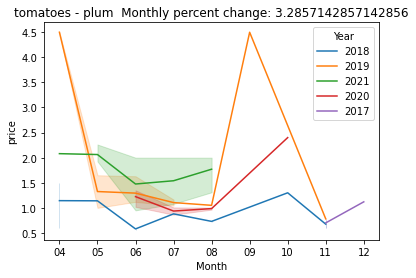

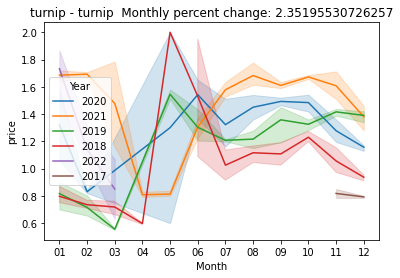

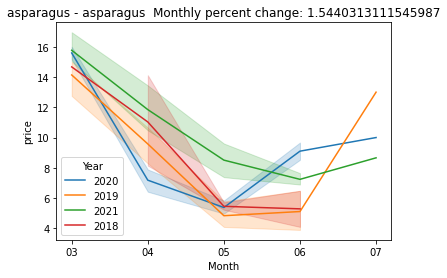

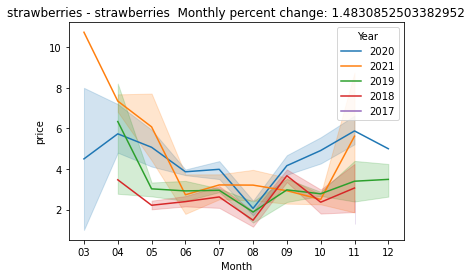

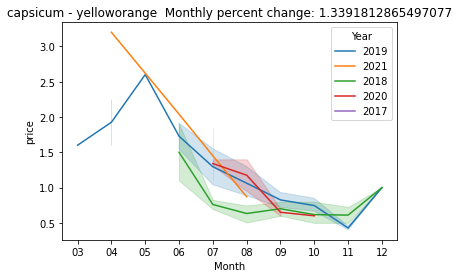

In [46]:
for index, row in top5Monthly.iterrows():
    thisData = data[(data['item']==row['item'])&(data['variety']==row['variety'])]
    thisData = thisData.sort_values(by='Month')
    
    rel = sns.lineplot(data = thisData,x="Month", y='price',hue ='Year')
    plt.title('{0} - {1}  Monthly percent change: {2}'.format(row['item'],row['variety'],row['MonthlyPercentChange']))
    plt.show()